# Setup Libraries

Needed in google colab

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 957 kB/s 
     |████████████████████████████████| 6.4 MB 26.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
#import matplotlib.mlab as mlab 
%matplotlib inline

# statistical calculation
#from scipy.stats import norm

import datetime as dt # For defining dates

import time

import yfinance as yf

# Get Stock Data

In [3]:
all_stocks = ["^GSPC", "^FTLC", "^RUT", "IEUS", "GOVT", "IGOV", "SIVR", "SGOL"]

In [4]:
def get_all_closes_of_stocks(tickers):
  i = 0
  stock_list = pd.DataFrame()
  for ticker in tickers:
    stock = yf.Ticker(ticker)        
    data = stock.history(start="2012-02-24",end ="2022-02-25")
    data.drop(data.columns[[0,1,2,4,5,6]], axis=1, inplace=True) # Just gets the adjacent close for each asset
    data.columns = [ticker]
    stock_list[ticker] = data.iloc[:,0]
  return stock_list.dropna()
stock_data = get_all_closes_of_stocks(all_stocks)
print(stock_data)

                  ^GSPC        ^FTLC         ^RUT       IEUS       GOVT  \
Date                                                                      
2012-02-24  1365.739990  3144.399902   826.919983  27.285177  21.551907   
2012-02-27  1367.589966  3133.399902   826.659973  27.201170  21.551907   
2012-02-28  1372.180054  3141.199951   823.799988  27.445541  21.551907   
2012-02-29  1365.680054  3112.399902   810.940002  27.155359  21.551907   
2012-03-01  1374.089966  3142.899902   815.219971  27.117170  21.551907   
...                 ...          ...          ...        ...        ...   
2022-02-17  4380.259766  4240.200195  2028.089966  63.590000  25.511515   
2022-02-18  4348.870117  4222.799805  2009.329956  62.840000  25.571404   
2022-02-22  4304.759766  4201.799805  1980.170044  61.560001  25.581383   
2022-02-23  4225.500000  4198.799805  1944.089966  60.889999  25.461611   
2022-02-24  4288.700195  4042.899902  1996.010010  60.000000  25.471592   

                 IGOV   

# Bayesian Linear Regression Weights

In [5]:
class BayesLinearRegressor:
    def __init__(
        self, number_of_features, mean=None, cov=None, alpha=1e6, beta=1
    ):
        # prior distribution on weights
        if mean is None:
            self.mean = np.array([[0] * (number_of_features)], dtype=float).T

        if cov is None:
            self.cov = alpha * np.identity(number_of_features)
            self.cov_inv = np.linalg.inv(self.cov)
            self.cov_init = self.cov

        self.beta = beta  # process noise
        self.number_of_features = number_of_features

    def fit(self, x, y):
        return self.update(x, y)

    def update(self, x, y, inc_alpha=None):
        """
        Perform a bayesian update step
        """
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[:, np.newaxis]

        # update state of covariance and means
        cov_n_inv = self.cov_inv + self.beta * x.T @ x
        cov_n = np.linalg.inv(cov_n_inv)
        mean_n = cov_n @ (self.cov_inv @ self.mean + self.beta * x.T @ y) # @ is matrix multiplication

        if inc_alpha is not None:
            # cov_n = cov_n - (cov_n - self.cov_init) * inc_alpha
            cov_n = cov_n + inc_alpha * np.identity(self.number_of_features)

            cov_n_inv = np.linalg.inv(cov_n)

        self.cov_inv = cov_n_inv
        #print(self.cov_inv)
        self.cov = cov_n
        #print(self.cov)
        self.mean = mean_n
        #print(self.mean)

    def predict(self, x):
        mean = x @ self.mean
        scale = np.sqrt(np.sum(x @ self.cov @ x.T, axis=1))
        return mean, scale

    @property
    def coef_(self):
        return self.mean

    @property
    def scale_(self):
        return np.sqrt(np.diag(self.cov))


In [6]:
daily_stock_returns = stock_data.iloc[:-252].pct_change().dropna() # remove the test year from the data
daily_stock_returns

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL
Date,,,,,,,,
2012-02-27,0.001355,-0.003498,-0.000314,-0.003079,0.000000,-0.001189,-0.000285,-0.003132
2012-02-28,0.003356,0.002489,-0.003460,0.008984,0.000000,0.007836,0.043020,0.010512
2012-02-29,-0.004737,-0.009168,-0.015611,-0.010573,0.000000,-0.004921,-0.064736,-0.053030
2012-03-01,0.006158,0.009800,0.005278,-0.001406,0.000000,-0.019891,0.027453,0.014149
2012-03-02,-0.003246,-0.002895,-0.015701,-0.002253,0.000000,-0.007479,-0.020182,-0.001766
...,...,...,...,...,...,...,...,...
2021-01-27,-0.025678,-0.012199,-0.019146,-0.026092,0.001104,-0.003997,-0.009756,-0.006180
2021-01-29,-0.009739,-0.020476,-0.016626,0.003389,-0.003308,-0.001277,0.066092,0.000565
2021-02-01,0.016052,0.009006,0.025327,0.012064,0.000775,-0.006210,0.072006,0.008475


In [7]:
stock_data["label"] = 1
daily_stock_returns["label"] = 1
# Use daily % stock data change to make sure the model uses normalised data

In [8]:
print(stock_data.drop(["label"],axis=1).shape[1])

8


In [9]:
daily_stock_returns

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL,label
Date,,,,,,,,,
2012-02-27,0.001355,-0.003498,-0.000314,-0.003079,0.000000,-0.001189,-0.000285,-0.003132,1
2012-02-28,0.003356,0.002489,-0.003460,0.008984,0.000000,0.007836,0.043020,0.010512,1
2012-02-29,-0.004737,-0.009168,-0.015611,-0.010573,0.000000,-0.004921,-0.064736,-0.053030,1
2012-03-01,0.006158,0.009800,0.005278,-0.001406,0.000000,-0.019891,0.027453,0.014149,1
2012-03-02,-0.003246,-0.002895,-0.015701,-0.002253,0.000000,-0.007479,-0.020182,-0.001766,1
...,...,...,...,...,...,...,...,...,...
2021-01-27,-0.025678,-0.012199,-0.019146,-0.026092,0.001104,-0.003997,-0.009756,-0.006180,1
2021-01-29,-0.009739,-0.020476,-0.016626,0.003389,-0.003308,-0.001277,0.066092,0.000565,1
2021-02-01,0.016052,0.009006,0.025327,0.012064,0.000775,-0.006210,0.072006,0.008475,1


In [10]:
bayes_linear_regression = BayesLinearRegressor(daily_stock_returns.drop(["label"],axis=1).shape[1])

params_mu_seq = []
params_std_seq = []
for idx in range(len(daily_stock_returns)):
    bayes_linear_regression.update(
        daily_stock_returns.drop(["label"],axis=1).iloc[idx,:],
        np.array([1]),
    )

    params_mu_seq.append(bayes_linear_regression.coef_.flatten())
    params_std_seq.append(bayes_linear_regression.scale_)

params_mu_seq = pd.DataFrame(params_mu_seq)
params_std_seq = pd.DataFrame(params_std_seq)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [11]:
df_coeff = pd.DataFrame(daily_stock_returns.drop(["label"],axis=1).columns)
df_coeff.columns = ["TICKER"]
df_coeff["coeff"] = bayes_linear_regression.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum())

df_coeff["weight"] are the weights of the portfolio. It is very heavy towards bonds and commodities which is interesting

In [12]:
print()
print(df_coeff.sum())

  TICKER      coeff    weight
0  ^GSPC   8.134443  0.153105
1  ^FTLC  -2.957161  0.055659
2   ^RUT  -0.321098  0.006044
3   IEUS   2.595754  0.048857
4   GOVT  32.930695  0.619815
5   IGOV  -4.178373  0.078644
6   SIVR  -1.499229  0.028218
7   SGOL   0.513158  0.009659
TICKER    ^GSPC^FTLC^RUTIEUSGOVTIGOVSIVRSGOL
coeff                              35.218189
weight                                   1.0
dtype: object


## Format the weights

In [56]:
portfolio_weights = df_coeff["weight"]#.to_frame().transpose() #pd.DataFrame(, columns=all_stocks)
portfolio_weights = portfolio_weights.to_numpy().reshape(-1,8)
portfolio_weights = pd.DataFrame(portfolio_weights, columns=all_stocks)
portfolio_weights

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL
0,0.153105,0.055659,0.006044,0.048857,0.619815,0.078644,0.028218,0.009659


## Benchmark on the Test Year Only

Note to self for now you multiply column by column. If indecies don't match you won't multiply

In [59]:
portfolio_weights = pd.Series([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], index=all_stocks) # Defining an equally weighted portfolio
initial_investment = 10000 # 10'000 dollar invesment. Can Change to 100'000 later 
trading_year = 252 # Number of trading days in a year
stock_returns = stock_data.pct_change() 

In [60]:
weighted_portfolio = portfolio_weights * initial_investment # Calculate the dollars invested in each asset in the portfolio
num_of_shares = weighted_portfolio / stock_data.iloc[(-trading_year),:] # Calculate the number of shares owned of each asset in the portfolio
portfolio_test_values = num_of_shares * stock_data.iloc[(-trading_year):,:] # share * share price = position value and it is done for each day in the trading year for all assets
portfolio_test_values['Total'] = portfolio_test_values.sum(axis=1)
portfolio_test_values

,GOVT,IEUS,IGOV,SGOL,SIVR,^FTLC,^GSPC,^RUT,label,Total
Date,,,,,,,,,,
2021-02-04,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,NaN,10000.000000
2021-02-05,1248.146167,1263.075659,1255.790325,1262.325992,1274.057428,1250.536441,1254.871869,1267.543292,NaN,10076.347172
2021-02-08,1248.609804,1269.906171,1257.179921,1274.651984,1296.641830,1256.135191,1264.157103,1299.570524,NaN,10166.852528
2021-02-09,1249.536631,1275.761125,1264.823100,1278.277218,1290.259310,1257.677317,1262.749433,1304.814750,NaN,10183.898884
2021-02-10,1251.854102,1269.906171,1263.201830,1283.352741,1280.930926,1255.263494,1262.313550,1295.415964,NaN,10162.238778
...,...,...,...,...,...,...,...,...,...,...
2022-02-17,1196.243125,1273.875805,1126.281228,1321.055652,1127.258440,1421.550287,1414.176758,1151.057722,NaN,10031.499017
2022-02-18,1199.051332,1258.851322,1124.886221,1319.605641,1131.186260,1415.716711,1404.042539,1140.410337,NaN,9993.750364
2022-02-22,1199.519263,1233.209563,1123.723686,1322.505801,1141.987484,1408.676346,1389.801412,1123.860409,NaN,9943.283964


### Plot the portfolio

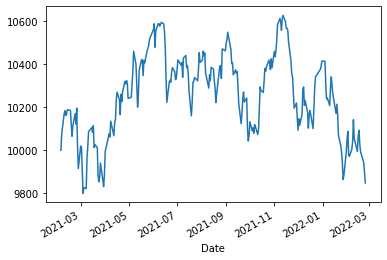

In [61]:
portfolio_test_values['Total'].plot() # Need to pretty this up for the dssertation

### Plot the Individual Assets

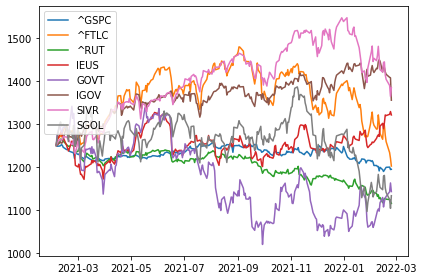

In [62]:
# Plotted on the same graph to see general trend
figure = plt.figure()
axis = plt.plot(portfolio_test_values.iloc[:,0:1], label='^GSPC')
axis = plt.plot(portfolio_test_values.iloc[:,1:2], label='^FTLC')
axis = plt.plot(portfolio_test_values.iloc[:,2:3], label='^RUT')
axis = plt.plot(portfolio_test_values.iloc[:,3:4], label='IEUS')

axis = plt.plot(portfolio_test_values.iloc[:,4:5], label='GOVT')
axis = plt.plot(portfolio_test_values.iloc[:,5:6], label='IGOV')
axis = plt.plot(portfolio_test_values.iloc[:,6:7], label='SIVR')
axis = plt.plot(portfolio_test_values.iloc[:,7:8], label='SGOL')
plt.tight_layout()
plt.legend()
plt.show()

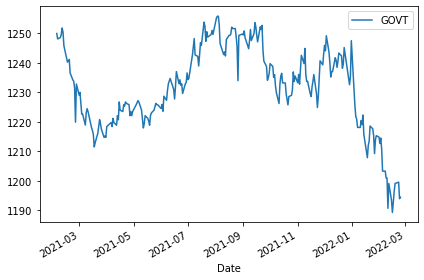

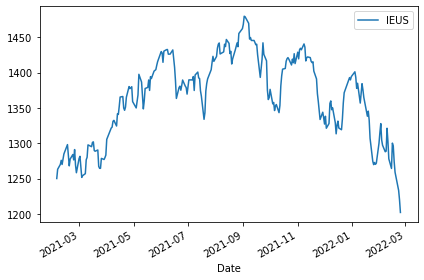

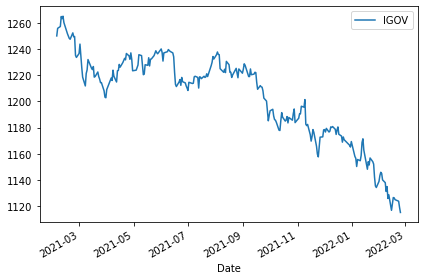

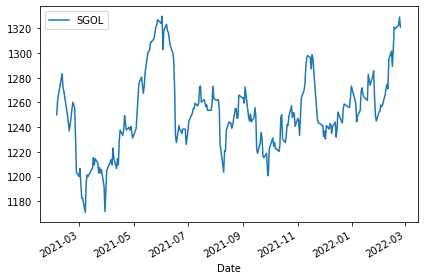

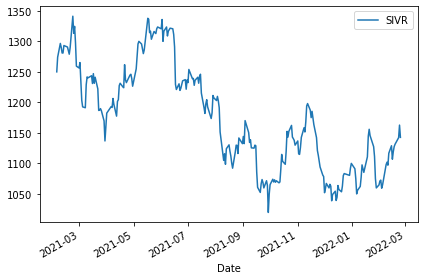

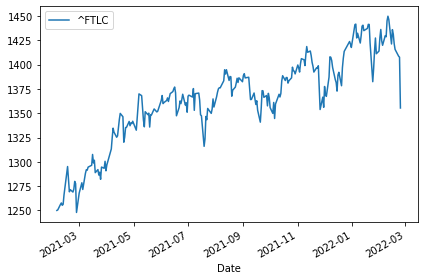

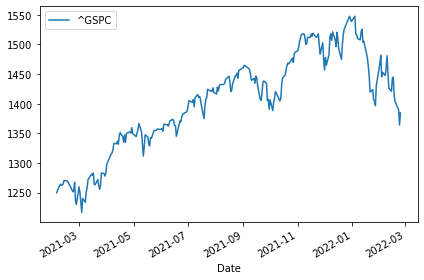

In [63]:
for i in range(1,8):
  portfolio_test_values.iloc[:,(i-1):i].plot()
  plt.tight_layout()
  plt.show()

# Analyse the Test Year

## Sharpe Ratio

GOVT    NaN
IEUS    NaN
IGOV    NaN
SGOL    NaN
SIVR    NaN
^FTLC   NaN
^GSPC   NaN
^RUT    NaN
label   NaN
Total   NaN
dtype: float64

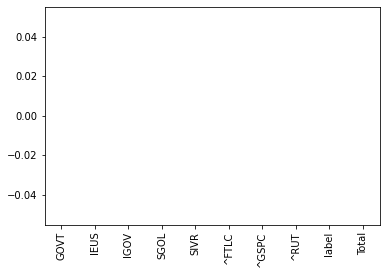

In [64]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()
#print(daily_stock_returns.iloc[250,:-1])
# To calculate sharpie ratio for individual stocks 
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 252 #252 trading days in a year
rf =0 #1% risk free rate Will need to update this to the US treasury field or something. I assume this to be 0 in my dissertation
#The risk-free rate could be a U.S. Treasury rate or yield, such as the one-year or two-year Treasury yield.
sharpes = daily_stock_returns.apply(sharpe_ratio, args=(N,rf,),axis=0)
#total_stock_returns = daily_stock_returns.iloc[250,:-1]
#sharpes2 = sharpe_ratio(total_stock_returns, N, rf)
#print(total_stock_returns)
# Need to look at the returns which price doesn't give
#print(portfolio_test_values.iloc[251:252,:].drop(["date"],axis=1))
#print(portfolio_test_values.iloc[251:252,:].reset_index().drop("Date", axis=1))
#val_returns = (portfolio_test_values.iloc[251:252,:].reset_index().drop("Date", axis=1) - portfolio_test_values.iloc[0:1,:].reset_index().drop("Date", axis=1) ) /  portfolio_test_values.iloc[0:1,:].reset_index().drop("Date", axis=1)
#print(portfolio_test_values.diff())
#sharpes2 = portfolio_test_values.diff().apply(sharpe_ratio, args=(N,rf,),axis=0)
#print(sharpes2)
sharpes.plot.bar()
sharpes

## Volatility

### Individual Stock Volatility

#### Rolling Volatilty for Each stock

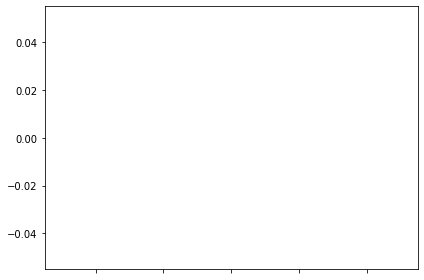

In [65]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
rolling_stock = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
for stock in all_stocks:
  rolling_stock[stock] = data[stock].rolling(7).std()*(252**0.5)
f1 = plt.figure()
for i in range(0,7):
  rolling_stock.iloc[:,i].plot()
  plt.tight_layout()
  #plt.show() # To display in separate graphs instead of 1

#### Anualised volatility for Each Stock

In [66]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
stock_volatility = pd.DataFrame()
data = portfolio_test_values.pct_change().dropna()
tmp = pd.DataFrame()
i = 0 
for stock in all_stocks:
  tmp[stock] = data.iloc[:,i:(i+1)]
  stock_volatility = tmp.std()*(252**0.5)
  i = i + 1
print(stock_volatility)

^GSPC   NaN
^FTLC   NaN
^RUT    NaN
IEUS    NaN
GOVT    NaN
IGOV    NaN
SIVR    NaN
SGOL    NaN
dtype: float64


### Portfolio Volatility

#### Just the Anualised Volatility for the Portfolio

In [67]:
total_portfolio_change = portfolio_test_values['Total'].pct_change().dropna()
portfolio_vol = total_portfolio_change.std()*(252**0.5)
portfolio_vol

0.09713137131595187

## Maximum Drawdown

GOVT    NaN
IEUS    NaN
IGOV    NaN
SGOL    NaN
SIVR    NaN
^FTLC   NaN
^GSPC   NaN
^RUT    NaN
label   NaN
Total   NaN
dtype: float64

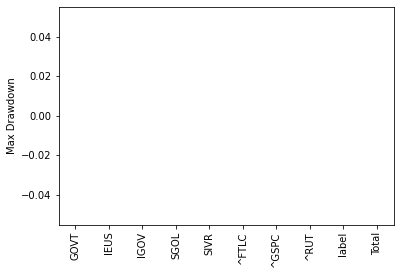

In [68]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

daily_stock_returns = portfolio_test_values.pct_change().dropna()
max_drawdowns = daily_stock_returns.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')
max_drawdowns

## Compound Annual Growth Rate (CARG)

In [69]:
start_value = portfolio_test_values.iloc[0,:]
end_value = portfolio_test_values.iloc[-1,:]
number_of_years =  round(len(portfolio_test_values)/252)
CARG = (((end_value / start_value) ** (1/number_of_years)) -1)# Shows % of values
CARG

GOVT    -0.044503
IEUS    -0.038433
IGOV    -0.107903
SGOL     0.056845
SIVR    -0.086017
^FTLC    0.084323
^GSPC    0.107693
^RUT    -0.093720
label         NaN
Total   -0.015214
dtype: float64

## Calmar Ratio

GOVT    NaN
IEUS    NaN
IGOV    NaN
SGOL    NaN
SIVR    NaN
^FTLC   NaN
^GSPC   NaN
^RUT    NaN
label   NaN
Total   NaN
dtype: float64

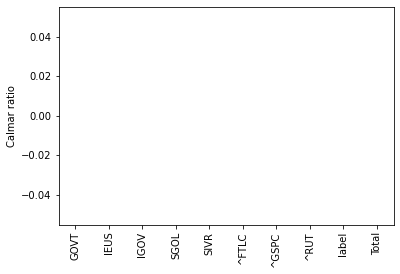

In [70]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change().dropna()

calmars = daily_stock_returns.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')
calmars

## Value at Risk? Haven't decided if I want to include this or not

# Export the Benchmark for the Test Year to a CSV

In [71]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [72]:
portfolio_test_values.to_csv('BayesianLinearRegressionData.csv')

In [73]:
portfolio_test_values.to_csv('BayesianLinearRegressionWeights.csv')

In [74]:
!cp BayesianLinearRegressionData.csv "drive/My Drive/DisData"

In [75]:
!cp BayesianLinearRegressionWeights.csv "drive/My Drive/DisData"